### math 510 project

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# constants

N = 200         # number of neurons (200)
M = 5           # number of external inputs to the network (?)
T = 1           # total time of the simulation (?)
delta_t = 0.001 # length of the time step (?)
tau = 0.03      # relaxation time constant (0.03)
g = 1.5         # scaling factor (1.5)

In [19]:
# initialize the activations x to uniform noise in the range [-0.1, 0.1]

x = 0.1 * (2 * np.random.rand(N,1) - 1)

In [20]:
# initialize the external inputs

u = np.zeros((M,1))

In [21]:
# initialize the weights J, taken from normal distribution with
# mean 0 and standard deviation g / sqrt(N)

J = np.random.normal(loc=0.0, scale=(g/np.sqrt(N)), size=(N,N))

In [22]:
# initialize the (external) weights B, taken from uniform distribution
# over [-1, 1]

B = 2 * np.random.rand(N,M) - 1

In [23]:
# calculate dx/dt (equation 3, p. 18)

def calculate_response(x):
    return np.tanh(x)

def calculate_derivative(x, u, J, B, tau):
    r = calculate_response(x)
    return (1.0 / tau) * (-x + np.dot(J,r) + np.dot(B,u))

In [24]:
# calculate euler approximation of the time step

def euler_timestep(x, u, J, B, tau, delta_t):
    return x + calculate_derivative(x, u, J, B, tau) * delta_t

In [25]:
def apply_perturbations(x, p, N):
    positions = np.random.rand(N,1) < p
    perturbations = np.random.rand(N,1) - 0.5
    return x + positions * perturbations

In [26]:
def enforce_biases(x):
    x[10][0] = 1.0
    x[11][0] = 1.0
    x[12][0] = -1.0
    return x

In [27]:
# run the simulation of the updates to the excitation

r_s = []  # keep track of resposne(x[0]) over time for the plot
t_s = []  # trial numbers for the plot

for timestep in range(int(round(T/delta_t))):
    x = euler_timestep(x, u, J, B, tau, delta_t)
    r_s.append(calculate_response(x[0][0]))
    t_s.append(timestep)
    #print "timestep:", timestep
    #print x

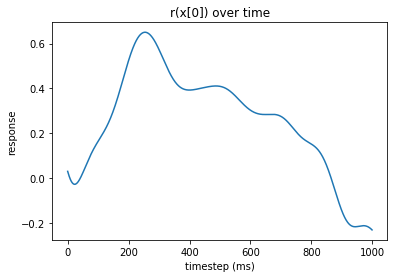

In [28]:
# plot r_s against t_s
plt.plot(t_s, r_s)
plt.title('r(x[0]) over time')
plt.xlabel('timestep (ms)')
plt.ylabel('response')
plt.show()

In [29]:
# rough template for running a trial

def update_learning_potential(E, x_prev, x, x_average, N):
    s = lambda x: np.power(x, 3)  # supralinear modification
    R = np.repeat(calculate_response(x_prev), N).reshape(N,N).transpose()
    X_DIFF = np.repeat(x - x_average, N).reshape(N,N)
    return E + s(R * X_DIFF)

# runs a trial -- returns the weight change
def run_trial(x, u, J, B, tau, delta_t, N, reward_function, eta):
    E = np.zeros((N,N))  # how to initialize learning potential?
    x_alpha = 0.75       # decay of short-term running average of x
    for timestep in range(int(round(T/delta_t))):
        x_prev = np.copy(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        E = update_learning_potential(E, x_prev, x, x_average, N)
        #TODO: where to apply neuron perturbation?
    r = reward_function()  # reward calculation differs from task to task
    return eta * r * E
        

In [30]:
# first task
import random

# runs a trial -- returns the weight change
def run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = False):
    E = np.zeros((N,N))  # how to initialize learning potential?
    x_alpha = 0.95       # decay of short-term running average of x
    r_alpha = 0.75       # decay of expected reward
    p = 3.0 / 1000       # probability of perturbation
    
    external = {'A': np.array([1.,0.]).reshape(2,1), 'B': np.array([0.,1.]).reshape(2,1)}
    
    choice1 = random.choice(['A', 'B'])
    if plot_output: print "Stimulus 1:", choice1
    u = external[choice1]
    
    x = 0.1 * (2 * np.random.rand(N,1) - 1)
    x_average = np.zeros((N,1))
    r_s = []
    
    for timestep in range(200):  # present first stimulus for 200 ms
        x_prev = np.copy(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x = apply_perturbations(x, p, N)
        x = enforce_biases(x)
        E = update_learning_potential(E, x_prev, x, x_average, N)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        #TODO: where to apply neuron perturbation?
        if plot_output: r_s.append(calculate_response(x[0][0]))
            
    u = np.zeros((M,1))
    for timestep in range(200):  # no external stimulus for 200 ms
        x_prev = np.copy(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x = apply_perturbations(x, p, N)
        x = enforce_biases(x)
        E = update_learning_potential(E, x_prev, x, x_average, N)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        #TODO: where to apply neuron perturbation?
        if plot_output: r_s.append(calculate_response(x[0][0]))
            
    choice2 = random.choice(['A', 'B'])
    if plot_output: print "Stimulus 2:", choice2
    u = external[choice2]
    for timestep in range(200):  # present first stimulus for 200 ms
        x_prev = np.copy(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x = apply_perturbations(x, p, N)
        x = enforce_biases(x)
        E = update_learning_potential(E, x_prev, x, x_average, N)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        #TODO: where to apply neuron perturbation?
        if plot_output: r_s.append(calculate_response(x[0][0]))
            
    u = np.zeros((M,1))
    for timestep in range(200):  # no external stimulus for 200 ms
        x_prev = np.copy(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x = apply_perturbations(x, p, N)
        x = enforce_biases(x)
        E = update_learning_potential(E, x_prev, x, x_average, N)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        #TODO: where to apply neuron perturbation?
        if plot_output: r_s.append(calculate_response(x[0][0]))
            
    target_response = -1 if choice1 == choice2 else 1
    trial_error = 0.0
    for timestep in range(200):  # measure error for 200 ms
        x_prev = np.copy(x)
        x = euler_timestep(x, u, J, B, tau, delta_t)
        x = apply_perturbations(x, p, N)
        x = enforce_biases(x)
        E = update_learning_potential(E, x_prev, x, x_average, N)
        x_average = x_alpha * x + (1 - x_alpha) * x_average
        measured_response = calculate_response(x[0][0])  # take x[0] to be output neuron
        trial_error += np.abs(target_response - measured_response)
        #TODO: where to apply neuron perturbation?
        if plot_output: r_s.append(calculate_response(x[0][0]))
            
    trial_error /= 200
    trial_type = choice1 == choice2
    trial_reward = trial_error - expected_reward[trial_type]
    prev_expected_reward = expected_reward[trial_type]
    expected_reward[trial_type] = r_alpha * expected_reward[trial_type] + (1 - r_alpha) * trial_error
    #print
    #print E
    #print
    return (eta * trial_reward * prev_expected_reward * E, expected_reward, trial_error, r_s)  # return (weight_change, expected_reward, trial_error, r_s) tuple

def task1(num_trials):
    
    N = 200         # number of neurons (200)
    M = 2           # number of external inputs to the network (2)
    T = 1           # total time of the simulation (?)
    delta_t = 0.001 # length of the time step (1 ms)
    tau = 0.03      # relaxation time constant (30 ms)
    g = 1.5         # scaling factor (1.5)
    eta = 0.1       # learning rate (0.5 paper, 0.1 code)
    
    
    J = np.random.normal(loc=0.0, scale=(g/np.sqrt(N)), size=(N,N))
    B = 2 * np.random.rand(N,M) - 1
    
    expected_reward = {True: 0.0, False: 0.0}
    
    e_s = []
    t_s = []
    
    # plot the output before training
    print "BEFORE TRAINING"
    print "==============="
    _, _, _, r_s = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = True)
    plt.plot(list(range(1000)), r_s)
    plt.title('r(x[0]) over time')
    plt.xlabel('timestep (ms)')
    plt.ylabel('response')
    plt.show()

    print
    print J
    print
    
    for trial in range(num_trials):
        weight_change, expected_reward, trial_error, _ = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta)
        #print
        #print weight_change
        #print
        J -= weight_change
        e_s.append(trial_error)
        t_s.append(trial)
    
    
    
    # plot the output before training
    print "AFTER TRAINING"
    print "=============="
    _, _, _, r_s = run_trial_task_1(J, B, tau, delta_t, N, M, expected_reward, eta, plot_output = True)
    plt.plot(list(range(1000)), r_s)
    plt.title('r(x[0]) over time')
    plt.xlabel('timestep (ms)')
    plt.ylabel('response')
    plt.show()
    
    print
    print J
    print
    
    # plot error
    plt.plot(t_s, e_s)
    plt.title('trial error over time')
    plt.xlabel('trial')
    plt.ylabel('error')
    plt.show()
    
    return

BEFORE TRAINING
Stimulus 1: B
Stimulus 2: B


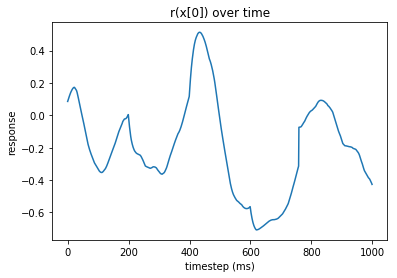


[[ 0.06549002 -0.13492877 -0.03069794 ...,  0.08474925  0.00719679
   0.06574892]
 [-0.17382124  0.12815427 -0.01667106 ...,  0.00803944  0.10491877
  -0.0876572 ]
 [ 0.03381902 -0.11432413  0.0359813  ...,  0.00801413  0.05276305
  -0.06184614]
 ..., 
 [-0.06889025 -0.00508885  0.16909737 ...,  0.04639032  0.03270123
   0.11326215]
 [ 0.13750035 -0.052206   -0.04029727 ...,  0.08155064  0.05699983
  -0.12970437]
 [ 0.03451558 -0.09511809  0.09473768 ...,  0.06686322 -0.13709834
   0.0740822 ]]



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys


AFTER TRAINING
Stimulus 1: A
Stimulus 2: A


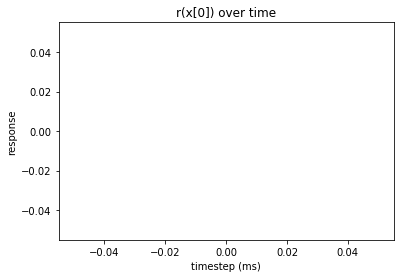


[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]



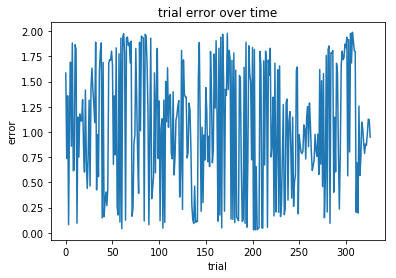

In [34]:
task1(500)